## Layer 1

Load the files in spark dataframes because no other option worked.

In [0]:
from pyspark.sql import functions as F

In [0]:
item_df = spark.read.csv(
    "s3a://merkle-de-interview-case-study/de/item.csv",
    header=True,
    inferSchema=False,
    multiLine=False
)

item_df.write.mode("overwrite").saveAsTable("raw_layer.item_raw")

In [0]:
# do the same for the 2nd file

event_df = spark.read.csv(
    "s3a://merkle-de-interview-case-study/de/event.csv",
    header=True,
    inferSchema=False,
    multiLine=False,
    quote='"',       # treat double quotes as enclosing quotes
    escape='"'
)

event_df.write.mode("overwrite").saveAsTable("raw_layer.event_raw")

### Saving to my bronze layer

In [0]:
bucket = "s3://my-de-case-study-datalake/"

In [0]:
event_df.write \
    .format("delta") \
    .mode("overwrite") \
    .save(f"{bucket}bronze/event_raw")

In [0]:
item_df.write \
    .format("delta") \
    .mode("overwrite") \
    .save(f"{bucket}bronze/item_raw")

In [0]:
item_df = spark.read.format("delta").load(f"{bucket}bronze/item_raw")
event_df = spark.read.format("delta").load(f"{bucket}bronze/event_raw")

## Understanding the structure

In [0]:
display(item_df.head(10))

adjective category created_at id modifier name price fuzzy contraption 2014-01-15 21:36:09 2512.0 carrying_case fuzzy contraption carrying_case 150.0 null instrument 2013-05-14 05:20:50 482.0 refill instrument refill 35.2 industrial-strength module 2014-02-04 19:28:32 2446.0 null industrial-strength module 300.0 digital tool 2013-02-25 12:23:18 1312.0 carrying_case digital tool carrying_case 16.5 miniature device 2013-08-05 17:20:45 3556.0 cleaner miniature device cleaner 16.5 rechargable contraption 2013-09-12 06:27:01 131.0 cleaner rechargable contraption cleaner 195.0 null instrument 2013-10-07 09:38:14 1178.0 how-to-manual instrument how-to-manual 0.0 prize-winning mechanism 2013-09-09 09:32:18 110.0 storage_unit prize-winning mechanism storage_unit 41.25 null mechanism 2013-10-25 22:53:25 47.0 null mechanism 15.0 organic tool 2013-05-10 10:19:33 1696.0 null organic tool 37.5

In [0]:
item_df.printSchema()

root
 |-- adjective: string (nullable = true)
 |-- category: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- id: string (nullable = true)
 |-- modifier: string (nullable = true)
 |-- name: string (nullable = true)
 |-- price: string (nullable = true)



Check if there are any null category rows

In [0]:
from pyspark.sql import functions as F

null_category_row = item_df.filter(F.col("category").isNull()).limit(1)
display(null_category_row)

adjective category created_at id modifier name price

As expected, category is mandatory

In [0]:
display(event_df.head(10))

event_id event_time user_id event.payload b9de71c5c3cc4cd7a97e50b832106e5a 2017-06-26 11:23:39 178481.0 {"event_name":"view_item","platform":"android","parameter_name":"item_id","parameter_value":"3526"} 23267713c9ea44419331731f50b6a8db 2017-06-27 10:46:39 178481.0 {"event_name":"view_item","platform":"android","parameter_name":"item_id","parameter_value":"1514"} 1b7822fa7b854e01970218ae8f721fe0 2017-06-27 11:15:39 178481.0 {"event_name":"view_item","platform":"android","parameter_name":"item_id","parameter_value":"3712"} 2a7a188a626841ac94befcc419f06af4 2016-10-05 20:43:10 154133.0 {"event_name":"view_item","platform":"android","parameter_name":"item_id","parameter_value":"3586"} 631d657264cc4616a4528f759509b25d 2016-10-04 03:29:10 154133.0 {"event_name":"view_item","platform":"android","parameter_name":"item_id","parameter_value":"1061"} 05e4df2fa9044bf9a49a7351fdd4a6cd 2016-07-21 01:17:43 119514.0 {"event_name":"view_item","platform":"web","parameter_name":"item_id","parameter_value":"550"} 22d3cdd566534fbdaa5e2982c1e64a75 2016-11-24 12:10:06 164581.0 {"event_name":"view_item","platform":"web","parameter_name":"item_id","parameter_value":"982"} cb0c825fe3804f42b602106580845b88 2016-11-23 21:13:06 164581.0 {"event_name":"view_item","platform":"web","parameter_name":"item_id","parameter_value":"858"} 181f7f97ab10440fb444810e085ded46 2016-11-25 20:06:06 164581.0 {"event_name":"view_item","platform":"web","parameter_name":"item_id","parameter_value":"3363"} bbbd68b2dbd04ecabacaa00e130a52f9 2018-02-06 06:19:55 232806.0 {"event_name":"view_item","platform":"web","parameter_name":"item_id","parameter_value":"2344"}

Check if the id column is a primary key on the items

In [0]:
# Check for duplicates
from pyspark.sql import functions as F
# Count occurrences per value
dupes = (
    item_df.groupBy("id")
      .agg(F.count("*").alias("cnt"))
      .filter(F.col("cnt") > 1)
)
# If no records are returned, no duplicates exist and id is a primary key column
display(dupes)

+---+---+
| id|cnt|
+---+---+
+---+---+



Seems like it can be used as one

Check if the event_id is unique on the events.

In [0]:
from pyspark.sql import functions as F

event_dupes = (
    event_df.groupBy(
        "event_id",
        #"user_id",
        #"event_time",
        #"`event.payload`"
    )
    .agg(F.count("*").alias("cnt"))
    .filter(F.col("cnt") == 2)
)
display(event_dupes)

event_id cnt 2d318a0fa0f5409aad8b6aa222980d14 2 769aff7dc9094d2b92e3d32f8c3ae6d8 2 e5089c8f57c5439fbe733a442fed8b05 2 986996ebb1874a5e84342b4cc09dff4e 2 57ea01fd618e4a72a7557ebed3843d1e 2 47d0fae89811450c903b069b5bdc7c11 2 5205556e195044a798bf661fa120218f 2 969b929e562b463aa8b15b3c6a162592 2 3b9d7e099f9c4a55ad70535a7dd76ef0 2 e3a5529d1427442a9eaa8cd649ed967a 2 c8a2afac8f284151940ecfe03d62fe46 2 08f24d6ce1824b83b76dde362a2f2eca 2 d7d3e89c4c4a44778043cf55c145175b 2 2ef57482e4bf4198bdc03824d9519219 2 7759bfc3b2ff4d73bf27668d1d9d3a47 2 44eefe41349941eaa70ce903d095c5c6 2 976e304a889745cea2a7c6c1352c39ce 2 d9aae16a813048d7b7e995b8a2e2473e 2 3b5d280b69e64c6695b268b5ab273a93 2 b98dd338c9b542e6a10303690c47fe3e 2 b64d4c138ae14378bfee7600eac24040 2 13beb74c91ba4898b63ff212219b4662 2 e845ac6ca91645b9bda29c1cf1312ab5 2 a4ac5eeed71e4430bd1f84a5d7396f1e 2 04706d42ef5e4d83bfc8367144fe4bd7 2 8aa5149ee24e489196b6a28810ff5ee6 2 b5a46e28809a40d4b0e4fd61839facd5 2 8491b6204c4b46f5b875411afa629b5b 2 1919036797b94aee881bde70ec9b0271 2 3e43c9801e2a45c8a6d6014dd11a79f4 2 699e3f83ba954b17888bcf81bbc66a6c 2 856600ab53564e7f9d11371d5ecd4fcf 2 4fcda9cef0dc4671a0f12860e5b100fa 2 c09c36d039ae4524befe1d2cf50f3769 2 9bb72a7d4030428fa24ffc2f066a1aea 2 685e840597da40c78523727d527b986f 2 b6f395e241ed424c9d8fb1cfc09ea641 2 63962b5e0c0b45e4be0bc6b3b6357843 2 2fbdff766ab546e4bee8b08c3002d701 2 5d55f680eb204125b92443328ea28d1f 2 406d99da005441e19b488a803e7f1567 2 cf64f650e7564304bc18d4268f5bb421 2 e84a75c63592492f9a1020d2fa94f23f 2 84b8aa132b134d6580191fd7b1a037c7 2 7b51eba7a43c479696f1192fc0ad5118 2 b600758c45004fe8bee38c22e967ad98 2 e6de9697226c4b92b4113164d262ff61 2 3d6eb234159a4ab791d6c9d9be4eb6ad 2 efa6b24fa05f407a8721def15c73f8b9 2 291cd6f7137e4c07ad04ca3e1c71d41c 2 08e5b53ff3c8432dafbaed994dd3c3fe 2 2c4239dc1b6748c2a67fb43b6f9aa4f6 2 e3b3c8db15b24fa28df131996dbdac20 2 197a4a5cdb2f4c599f6a3155eb571301 2 89ca092777464f9f82c7a75d4dcfbfe8 2 1daf3110d64f4734b031366c821e4fdd 2 6b9e2f44ae2045d0a5912b9b24409625 2 9a0e36d51c0245aeaefe9e20ba619bd3 2 316794c32a164b5d9679d720068c88f5 2 833441765f5644e69a48e5524acbc959 2 4308aae54ec5403d96f105c20eed8811 2 fb86d2373d894b8b84af80c726a18506 2 49c73db592c4443ab58ff3a4a18a3a5d 2 3fd02fbd9e5f421d8d658b298fb7ed2c 2 7271dbc039af44778a324aa8304cef5f 2 b24639bc396244c49505eca60a992bf5 2 1449755c644f4a1d92fa1464d0da620b 2 dc3d7b4b415841499f5f68e76898e37c 2 62eee99d47e14eefb1068468e81ed0a7 2 15d8a8e2a912476aa6327a5c29721364 2 b9317fe5b3274c3dab8955966a746975 2 44b908676ae24c999bcf6b8bb2d88401 2 65820a15a6004350a2b408c1577afe8a 2 bbf553e9980f42688f3dec2edb2309a1 2 30fcf8b55fcc4e3e8c82096d9a141bce 2 23c5f46cf70746d2aec8948b39b4111e 2 b8d6a3a3d833463c81c51f0d5c9b3d2d 2 0b65673a244c4fc8a980d63c42bb9c5d 2 a4665f62fb294dd6a39dbc305480fda8 2 89628f1087b54afab8a0a9c73a686808 2 fc434aedd8fd4e7fb607f04fe71cb388 2 f264d26ce2734f65ab994d1ff15a5376 2 99dc57abaead4bf298d8724a725ef6b3 2 26148aa72a2d43ec9e82ac3bb44fb721 2 ab1b6d80c1c644eeab4ca98400ea0cd8 2 0d3c30082b51435d99cc9878728780b4 2 04cf607f083741f8a5bece6ab2ceab18 2 ca8b7eb2ec954fa0b4d62b97f495ce14 2 64ecfb1d85b34152a2dc106307aa4c72 2 325c05491f854516a5a8a41b904df34e 2 12ea55ea9fe64d5fa2c556644783ca78 2 96a1b0e7bdec4cf09c37f7d55b701de3 2 2117cde0f83946edb06e88bfca702fae 2 c820c81f80f24769add8083f8e6d99c9 2 ebefb6f49e604d47b162be97c27d428b 2 5925ddad3b5241b6a0c2e8442d66b9ca 2 e0d11ec6445f46c29eb51ad862356ac4 2 b88bae0f2790441fb558f386353869cc 2 35a2a9058da24b588dcb613bc7a6e17c 2 1e25275d514044709b08f736d575df0b 2 86ca14d19c8e437fad569d1081e27e5d 2 94f5211a9ea0408c8b41333fba30763e 2 e8258e70eac94d3cb307ab52f5c921d1 2 2674f6a3c35c464eba65595937888060 2 6219b324372d45f694416a9d09d558a0 2 f8fa85ca8271497bbe77eb3b35fe685f 2 b16c1e1d5aaa483584c25df452e875c8 2 429f7601bd4c4703bf044cf72d5f6d8d 2 840807755b3c47829e2db31c8d5e9f6f 2 d92bdcd197d04572a421b7d3642ba4e3 2 f2d1af63f9154226ab4b22b91dcc6f01 2 36f8afadefea471c9ec3511fcd0d4747 2 ef7ec051053a4e1a852bcf2e0329cca5 2 561e8aeeec4045a7931f47be6ce373fe

We get duplicates. Let's check what each of them is

In [0]:
display(event_df.filter(event_df["event_id"] == "2d318a0fa0f5409aad8b6aa222980d14"))

event_id event_time user_id event.payload 2d318a0fa0f5409aad8b6aa222980d14 2014-04-12 21:17:57 11244.0 {"event_name":"view_item","platform":"web","parameter_name":"item_id","parameter_value":"404"} 2d318a0fa0f5409aad8b6aa222980d14 2014-04-12 21:17:57 11244.0 {"event_name":"view_item","platform":"web","parameter_name":"referrer","parameter_value":"promo_email_click"}

In [0]:
display(event_df.filter(event_df["event_id"] == "bf54a0bc2d3246e1ace7400c1fea4fcb"))

event_id event_time user_id event.payload bf54a0bc2d3246e1ace7400c1fea4fcb 2017-06-17 03:23:34 201919.0 {"event_name":"view_user_profile","platform":"web","parameter_name":"viewed_user_id","parameter_value":"97914"}

Seems like the view_item events have 2 rows, one is the request with info about where the user clicked from to get to the specific item page, and one with the response providing the item details.

## Layer 2

#### Check if the date columns have all valid rows

Doing the filtering separately so that I would be able to see the rows that are exceptions in each filter
Otherwise, I would be doing all the filtering at once to take advantage of the way that pyspark tells the compiler to run the operations in parallel.

In [0]:
from pyspark.sql import functions as F

#                   yyyy - MM  - dd    HH : mm  :  ss
datetime_regex = r"^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$"

invalid_dates = item_df.filter(~F.col("created_at").rlike(datetime_regex))
invalid_dates_event = event_df.filter(~F.col("event_time").rlike(datetime_regex))


if not invalid_dates.isEmpty():
    display(invalid_dates_event)
if not invalid_dates_event.isEmpty():
    display(invalid_dates)

In [0]:
from pyspark.sql import functions as F

# Check for id values that, when cast to float, have a non-zero decimal part
id_with_decimal = item_df.filter(
    (F.col("id").cast("float") % 1) != 0
)

user_id_with_decimal = event_df.filter(
    (F.col("user_id").cast("float") % 1) != 0
)

if not id_with_decimal.isEmpty():
    display(id_with_decimal)
if not user_id_with_decimal.isEmpty():
    display(user_id_with_decimal)

### Cast the proper types on the columns

In [0]:
from pyspark.sql import functions as F
item_df_parsed = (
    item_df
    .withColumn("adjective", F.col("adjective").cast("string"))
    .withColumn("category", F.col("category").cast("string"))
    .withColumn("created_at", F.to_timestamp("created_at", "yyyy-MM-dd HH:mm:ss"))
    .withColumn("id", F.col("id").cast("float").cast("int"))
    .withColumn("modifier", F.col("modifier").cast("string"))
    .withColumn("name", F.col("name").cast("string"))
    .withColumn("price", F.col("price").cast("float"))
)

##### Expand the nested struct of event.payload

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType

json_schema = StructType([
    StructField("event_name", StringType(), True),
    StructField("platform", StringType(), True),
    StructField("parameter_name", StringType(), True),
    StructField("parameter_value", StringType(), True)
])


In [0]:
from pyspark.sql.functions import from_json, col, to_timestamp

event_df_parsed = (
    event_df
    .withColumn(
        "event_payload_struct",
        from_json(col("`event.payload`"), json_schema)
    )
    .select(
        *[c for c in event_df.columns if c != "event.payload"],
        col("event_payload_struct.event_name").alias("payload_event_name"),
        col("event_payload_struct.platform").alias("payload_platform"),
        col("event_payload_struct.parameter_name").alias("payload_parameter_name"),
        col("event_payload_struct.parameter_value").alias("payload_parameter_value")
    )
    .withColumn("user_id", F.col("user_id").cast("float").cast("int"))
    .withColumn("event_time", F.to_timestamp("event_time", "yyyy-MM-dd HH:mm:ss"))
)

In [0]:
display(event_df_parsed)

The parameter value can be a string or a number so I leave it as a string

### Load the dataframes into the silver layer with no removals

In [0]:
from pyspark.sql.functions import year, col

# Add a partition column (year) to your events fact table
events_df_to_partition = (
    event_df_parsed
    .withColumn("year", F.year(col("event_time")))
    .withColumn("month", F.month(col("event_time")))
)

events_df_to_partition.write \
    .format("delta") \
    .mode("overwrite") \
    .partitionBy("year", "month", "payload_event_name") \
    .save(f"{bucket}/silver/event_fact")


In [0]:
from pyspark.sql.functions import col, when

# Calculate price quantiles to determine bucket edges
quantiles = item_df_parsed.approxQuantile("price", [0.25, 0.5, 0.75], 0.01)
q1, q2, q3 = quantiles

item_df_parsed_with_buckets = (
    item_df_parsed.withColumn(
        "price_bucket",
        when(col("price") < q1, "low")
        .when((col("price") >= q1) & (col("price") < q2), "medium-low")
        .when((col("price") >= q2) & (col("price") < q3), "medium-high")
        .otherwise("high")
        .cast(StringType())
    )
)

In [0]:
item_df_parsed_with_buckets.write.mode("overwrite").format("delta").partitionBy("category", "price_bucket").save(f"{bucket}/silver/item_clean")

### Check for distinct values of each attribute

In [0]:
display(item_df_parsed.groupBy("modifier").count())
display(item_df_parsed.groupBy("adjective").count())
display(item_df_parsed.groupBy("category").count())
display(item_df_parsed.groupBy("name").count())
display(item_df_parsed.groupBy("created_at").count())
display(item_df_parsed.groupBy("price").count())


+-------------+-----+
|     modifier|count|
+-------------+-----+
|      cleaner|  146|
|         NULL|  766|
| storage_unit|  186|
|       warmer|  139|
|      charger|  172|
|       opener|  169|
|how-to-manual|  156|
|      wrapper|  158|
|       refill|  162|
|carrying_case|  144|
+-------------+-----+

+-------------------+-----+
|          adjective|count|
+-------------------+-----+
|               NULL|  272|
|industrial-strength|  164|
|              matte|  142|
|      prize-winning|  153|
|            organic|  139|
|        aerodynamic|  153|
|     extra-strength|  153|
|         reflective|  168|
|              fuzzy|  153|
|        rechargable|  153|
|             glossy|  138|
|          miniature|  134|
|             analog|  148|
|            digital|  128|
+-------------------+-----+

+-----------+-----+
|   category|count|
+-----------+-----+
|     dongle|  211|
|     device|  216|
|  mechanism|  225|
|contraption|  206|
|     widget|  212|
|     gadget|  233|
|     

In [0]:
display(event_df_parsed.groupBy("payload_parameter_name").count())
display(event_df_parsed.groupBy("payload_event_name").count())
display(event_df_parsed.groupBy("payload_platform").count())


+----------------------+------+
|payload_parameter_name| count|
+----------------------+------+
|               item_id|262786|
|              referrer|262786|
|       test_assignment|162490|
|        viewed_user_id|  3088|
|               test_id|162490|
+----------------------+------+

+------------------+------+
|payload_event_name| count|
+------------------+------+
|         view_item|525572|
|   test_assignment|324980|
| view_user_profile|  3088|
+------------------+------+

+----------------+------+
|payload_platform| count|
+----------------+------+
|             iOS| 86514|
|         android| 87501|
|      mobile web| 87224|
|             web|267421|
|          server|324980|
+----------------+------+



#### Understand test_assignment

In [0]:
distinct_test_assignment_data = (
    event_df_parsed
    .filter(F.col("payload_event_name") == "test_assignment")
    .select("payload_platform","payload_parameter_name", "payload_parameter_value")
    .distinct()
)

display(distinct_test_assignment_data)

payload_platform payload_parameter_name payload_parameter_value server test_assignment 1 server test_id 4 server test_assignment 0 server test_id 5 server test_id 6 server test_id 7

Test assignment is either test_assignment parameter name with value 0 or 1
or
parameter name test_id with values 4-7,
both of which happen at 15:22:54 on the server.

#### Check what the rest event types are

In [0]:
event_df_filtered = event_df_parsed.filter(F.col("payload_event_name") != "test_assignment")

In [0]:
display(event_df_filtered.groupBy("payload_parameter_name").count())
display(event_df_filtered.groupBy("payload_event_name").count())
display(event_df_filtered.groupBy("payload_platform").count())

payload_parameter_name count item_id 262786 referrer 262786 viewed_user_id 3088

payload_event_name count view_item 525572 view_user_profile 3088

payload_platform count iOS 86514 android 87501 mobile web 87224 web 267421

item_id and referrer have the exact same number of rows, so it must be 2 events per click, 
1 to provide the referrer info and 1 to load the item details

In [0]:
event_df_no_viewed = event_df_filtered.filter(F.col("payload_parameter_name") != "viewed_user_id").orderBy(F.col("event_time").asc())
display(event_df_no_viewed)

event_id event_time user_id payload_event_name payload_platform payload_parameter_name payload_parameter_value 7c115a4a15114b6aaa5de3a60d561977 2013-03-09T09:28:22.000Z 50 view_item web referrer item_page 7c115a4a15114b6aaa5de3a60d561977 2013-03-09T09:28:22.000Z 50 view_item web item_id 1372 e247a9a5ec74466e8612c3127099c3ce 2013-03-10T13:30:31.000Z 9 view_item mobile web item_id 3928 e247a9a5ec74466e8612c3127099c3ce 2013-03-10T13:30:31.000Z 9 view_item mobile web referrer home d5d4533c3f684eb3ab55167d53d9d5b6 2013-03-10T23:09:31.000Z 9 view_item mobile web item_id 3780 d5d4533c3f684eb3ab55167d53d9d5b6 2013-03-10T23:09:31.000Z 9 view_item mobile web referrer home 86407869e79541589a91e937d4e2c6df 2013-03-11T03:47:31.000Z 9 view_item mobile web item_id 156 86407869e79541589a91e937d4e2c6df 2013-03-11T03:47:31.000Z 9 view_item mobile web referrer home 5fe103f9550b4b0b95502efefd3deb50 2013-03-11T07:36:22.000Z 50 view_item web item_id 603 5fe103f9550b4b0b95502efefd3deb50 2013-03-11T07:36:22.000Z 50 view_item web referrer item_page 849ce104888b43dfb5c2b2a935bd9f73 2013-03-11T12:12:31.000Z 9 view_item mobile web referrer home 849ce104888b43dfb5c2b2a935bd9f73 2013-03-11T12:12:31.000Z 9 view_item mobile web item_id 3953 9167a0861d1b4c48a30df6656debc848 2013-03-12T11:10:11.000Z 145 view_item web referrer home 9167a0861d1b4c48a30df6656debc848 2013-03-12T11:10:11.000Z 145 view_item web item_id 221 a98bc550f79d4a64860eb477d0d2c10c 2013-03-13T19:19:11.000Z 145 view_item web item_id 2233 a98bc550f79d4a64860eb477d0d2c10c 2013-03-13T19:19:11.000Z 145 view_item web referrer home 33a3985cc08746e490edab65c2f8855b 2013-03-13T21:10:44.000Z 91 view_item web item_id 2747 33a3985cc08746e490edab65c2f8855b 2013-03-13T21:10:44.000Z 91 view_item web referrer home 3aadc0d7025a4a518914b6c9ddf4bd66 2013-03-14T09:42:39.000Z 106 view_item iOS item_id 575 3aadc0d7025a4a518914b6c9ddf4bd66 2013-03-14T09:42:39.000Z 106 view_item iOS referrer shopping_cart 3adcf2f316c54cc5b60aea732db775e0 2013-03-14T14:55:39.000Z 106 view_item iOS item_id 1514 3adcf2f316c54cc5b60aea732db775e0 2013-03-14T14:55:39.000Z 106 view_item iOS referrer shopping_cart 5dff661704da45cda618f984085217f7 2013-03-16T00:03:48.000Z 54 view_item web referrer home 5dff661704da45cda618f984085217f7 2013-03-16T00:03:48.000Z 54 view_item web item_id 422 199241159eeb47d6a43f2522ab4a28c3 2013-03-16T00:56:12.000Z 215 view_item android referrer user_wishlist 199241159eeb47d6a43f2522ab4a28c3 2013-03-16T00:56:12.000Z 215 view_item android item_id 3003 5755b9bb46144306bc45b0e794ff8fd6 2013-03-16T22:18:48.000Z 54 view_item web referrer home 5755b9bb46144306bc45b0e794ff8fd6 2013-03-16T22:18:48.000Z 54 view_item web item_id 1017 fb11335a01ab4ad2af5a4dea86ae4408 2013-03-17T08:22:12.000Z 215 view_item android item_id 1805 fb11335a01ab4ad2af5a4dea86ae4408 2013-03-17T08:22:12.000Z 215 view_item android referrer user_wishlist b5d33a3fbdcb41d697fcf343b229ad16 2013-03-17T12:43:17.000Z 10 view_item iOS item_id 2730 b5d33a3fbdcb41d697fcf343b229ad16 2013-03-17T12:43:17.000Z 10 view_item iOS referrer home 0e6eb0b66ee4445da592e8f227dd9ee4 2013-03-17T16:48:48.000Z 54 view_item web referrer home 0e6eb0b66ee4445da592e8f227dd9ee4 2013-03-17T16:48:48.000Z 54 view_item web item_id 1310 0a70aeee4ba44c47a02d77dbf22c7f84 2013-03-18T01:30:17.000Z 10 view_item iOS item_id 1700 0a70aeee4ba44c47a02d77dbf22c7f84 2013-03-18T01:30:17.000Z 10 view_item iOS referrer home 658f338aa88d4c83ba755bf17f0a8e8d 2013-03-18T03:18:12.000Z 215 view_item android item_id 1064 b50286dad56d4e0e97d932bb9cf378a0 2013-03-18T03:18:12.000Z 215 view_item android item_id 1079 b50286dad56d4e0e97d932bb9cf378a0 2013-03-18T03:18:12.000Z 215 view_item android referrer user_wishlist 658f338aa88d4c83ba755bf17f0a8e8d 2013-03-18T03:18:12.000Z 215 view_item android referrer user_wishlist aa5d6435b52b4564bcde5008203e23be 2013-03-19T01:15:17.000Z 10 view_item iOS item_id 3964 aa5d6435b52b4564bcde5008203e23be 2013-03-19T01:15:17.000Z 10 view_item iOS referrer home b4eb6fd298bc4fde8

In [0]:
from pyspark.sql.functions import to_date

specific_day = "2017-06-26"

filtered_by_day = event_df_no_viewed.filter(
    to_date("event_time") == specific_day
)

In [0]:
display(filtered_by_day)

event_id event_time user_id payload_event_name payload_platform payload_parameter_name payload_parameter_value a3e62aaa1d9740dfbaae4b52793c14ac 2017-06-26T00:01:47.000Z 174713 view_item android item_id 3017 a3e62aaa1d9740dfbaae4b52793c14ac 2017-06-26T00:01:47.000Z 174713 view_item android referrer item_page 5a75c122ca16415992671a1c598668b4 2017-06-26T00:03:58.000Z 188072 view_item web item_id 375 5a75c122ca16415992671a1c598668b4 2017-06-26T00:03:58.000Z 188072 view_item web referrer user_wishlist e7f1f9fe06b5459fad2bd1c411c59bd9 2017-06-26T00:09:18.000Z 196529 view_item android referrer item_page e7f1f9fe06b5459fad2bd1c411c59bd9 2017-06-26T00:09:18.000Z 196529 view_item android item_id 1004 f2d064391c444149a7898f016023a2c1 2017-06-26T00:09:58.000Z 195559 view_item web item_id 250 f2d064391c444149a7898f016023a2c1 2017-06-26T00:09:58.000Z 195559 view_item web referrer shopping_cart 9914394ec545495b963df72c859dc485 2017-06-26T00:19:58.000Z 188072 view_item web item_id 1833 9914394ec545495b963df72c859dc485 2017-06-26T00:19:58.000Z 188072 view_item web referrer user_wishlist d09e1f6b7417472e8d0cb9bbfa398289 2017-06-26T00:26:22.000Z 192335 view_item android item_id 3672 d09e1f6b7417472e8d0cb9bbfa398289 2017-06-26T00:26:22.000Z 192335 view_item android referrer item_page 1d86ab0b8f93462994986da1eaea8891 2017-06-26T00:32:58.000Z 195104 view_item web referrer home 1d86ab0b8f93462994986da1eaea8891 2017-06-26T00:32:58.000Z 195104 view_item web item_id 2193 7e45e5d21796479ca8e99aa3d24f5244 2017-06-26T00:34:40.000Z 205628 view_item web item_id 561 7e45e5d21796479ca8e99aa3d24f5244 2017-06-26T00:34:40.000Z 205628 view_item web referrer item_page 6e11196ac82449409e30fe236e76c6bf 2017-06-26T00:38:07.000Z 191218 view_item iOS item_id 3847 6e11196ac82449409e30fe236e76c6bf 2017-06-26T00:38:07.000Z 191218 view_item iOS referrer google_search 2d32522a649147ab838f30f5c1c838e8 2017-06-26T00:38:36.000Z 182251 view_item web referrer home 2d32522a649147ab838f30f5c1c838e8 2017-06-26T00:38:36.000Z 182251 view_item web item_id 52 b9f15c5d7e1a4e78a07e32fa278bf2aa 2017-06-26T00:50:16.000Z 208927 view_item web item_id 79 b9f15c5d7e1a4e78a07e32fa278bf2aa 2017-06-26T00:50:16.000Z 208927 view_item web referrer home 1a9950062b554053b51c8395effde0c1 2017-06-26T01:05:08.000Z 190839 view_item mobile web item_id 1733 1a9950062b554053b51c8395effde0c1 2017-06-26T01:05:08.000Z 190839 view_item mobile web referrer promo_email_click 50ef1ebf91a545498402a0f0349d632e 2017-06-26T01:09:45.000Z 209213 view_item android item_id 2250 50ef1ebf91a545498402a0f0349d632e 2017-06-26T01:09:45.000Z 209213 view_item android referrer user_wishlist 9d94efa9d5ba4b14bb12c3958f7802ec 2017-06-26T01:10:44.000Z 198388 view_item iOS item_id 2463 9d94efa9d5ba4b14bb12c3958f7802ec 2017-06-26T01:10:44.000Z 198388 view_item iOS referrer home 2755a6499af5456485326026ad7a805b 2017-06-26T01:24:44.000Z 177947 view_item android referrer user_wishlist 2755a6499af5456485326026ad7a805b 2017-06-26T01:24:44.000Z 177947 view_item android item_id 3479 fad4cdb7ec364763837c1dc9e11f9f4e 2017-06-26T01:29:02.000Z 207225 view_item mobile web referrer home fad4cdb7ec364763837c1dc9e11f9f4e 2017-06-26T01:29:02.000Z 207225 view_item mobile web item_id 3160 68da79bde1104533999a61c84626e9e0 2017-06-26T02:03:37.000Z 187645 view_item web referrer google_search 68da79bde1104533999a61c84626e9e0 2017-06-26T02:03:37.000Z 187645 view_item web item_id 1854 ba404e3529f244b0b7ea309b02f3125c 2017-06-26T02:07:30.000Z 189409 view_item web referrer google_search ba404e3529f244b0b7ea309b02f3125c 2017-06-26T02:07:30.000Z 189409 view_item web item_id 1045 b6a6c7fbbcb1410388c043ae26d5c274 2017-06-26T02:14:28.000Z 197913 view_item mobile web item_id 1295 b6a6c7fbbcb1410388c043ae26d5c274 2017-06-26T02:14:28.000Z 197913 view_item mobile web referrer promo_email_click 12d1d55d5c194218bc8b07be622ea744 2017-06-26T02:16:15.000Z 178803 view_item mobile web referrer home 12d1d55d5c194218bc8b07be622ea744 2017-06-26T02:16:15.000Z 178803 view_item mobile

See distinct values for the referrer

In [0]:
referrer_rows = event_df_no_viewed.filter(F.col("payload_parameter_name") == "referrer")
display(referrer_rows.groupBy("payload_event_name").count())
display(referrer_rows.groupBy("payload_platform").count())
display(referrer_rows.groupBy("payload_parameter_value").count())

payload_event_name count view_item 262786

payload_platform count iOS 42982 android 43499 mobile web 43364 web 132941

payload_parameter_value count google_search 29251 home 86991 shopping_cart 59024 user_wishlist 29523 item_page 29460 promo_email_click 28537

In [0]:
display(
    referrer_rows.groupBy("payload_platform", "payload_parameter_value").count().orderBy("payload_platform")
)

payload_platform payload_parameter_value count android item_page 14449 android user_wishlist 14535 android home 14515 iOS shopping_cart 14082 iOS home 14374 iOS google_search 14526 mobile web promo_email_click 13895 mobile web shopping_cart 14732 mobile web home 14737 web google_search 14725 web item_page 15011 web promo_email_click 14642 web home 43365 web shopping_cart 30210 web user_wishlist 14988

referrer rows are only view_item events, so it corresponds to viewing items in the web store and the parameter value is where the item link was clicked from

In [0]:
item_df_parsed.write.mode("overwrite").format("delta").save(f"{bucket}/silver_layer/item")
event_df_parsed.write.mode("overwrite").format("delta").save(f"{bucket}/silver_layer/event")

### Visualizing the item prices

TODO: Plot the prices in logarithmic space

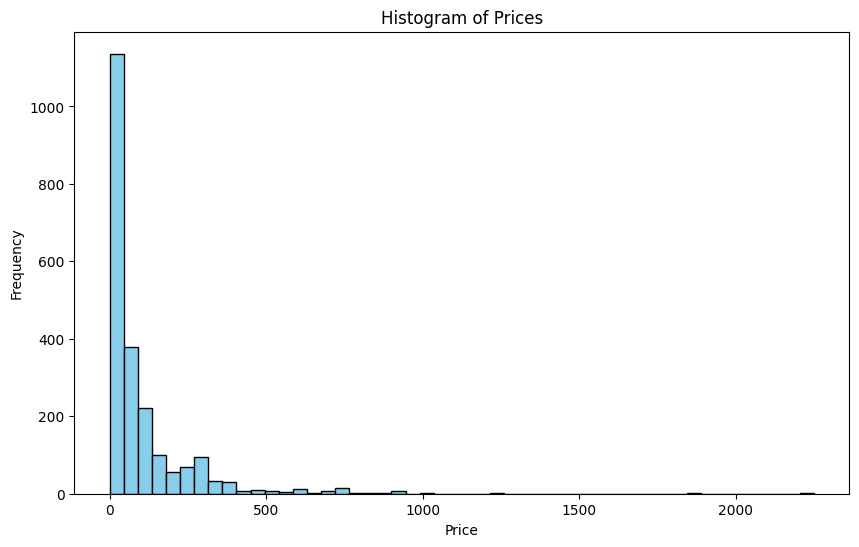

In [0]:
import matplotlib.pyplot as plt

prices_pd = item_df_parsed.select("price").toPandas()
plt.figure(figsize=(10, 6))
plt.hist(prices_pd["price"].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Histogram of Prices")
plt.show()

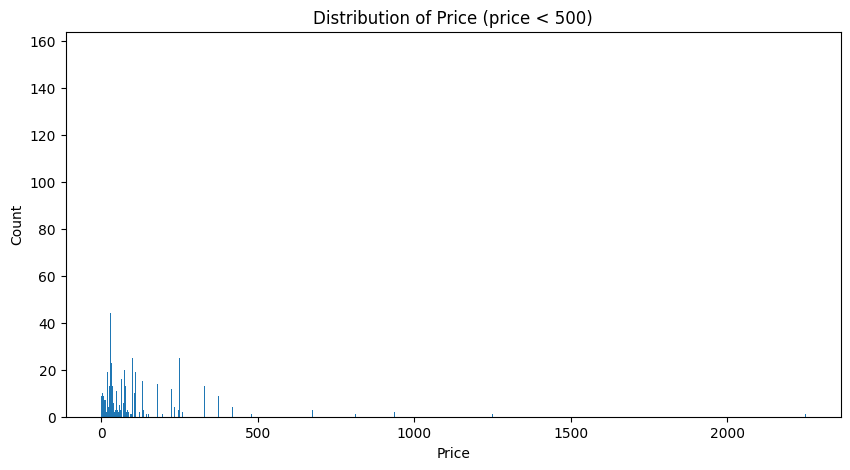

In [0]:
import matplotlib.pyplot as plt

# All values to see distribution
filtered_df = item_df_parsed#.filter((item_df_parsed["price"] < 500) & (item_df_parsed["price"] != 0))

price_counts = (
    filtered_df.groupBy("price")
      .count()
      .orderBy("price")
)

# Convert to Pandas for plotting
price_counts_pd = price_counts.toPandas()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(price_counts_pd["price"], price_counts_pd["count"])
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of Price (price < 500)")
plt.show()

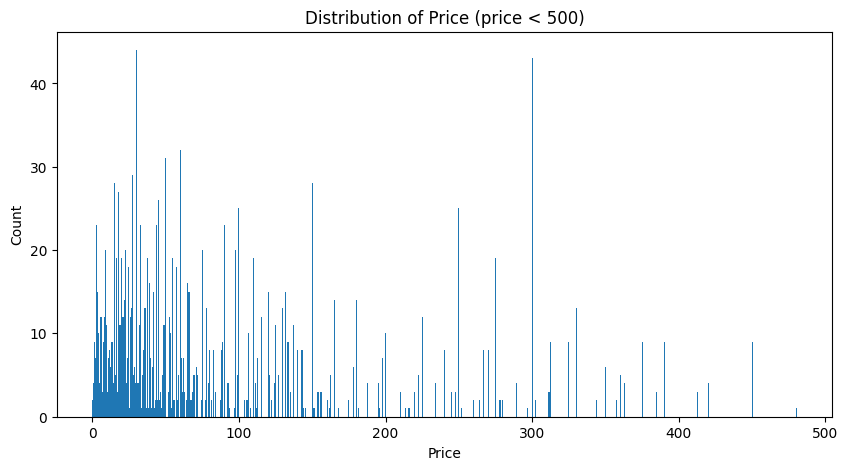

In [0]:
import matplotlib.pyplot as plt

# Filter for items with price < 500
# there are only how-to-manuals with price 0
filtered_df = item_df_parsed.filter((item_df_parsed["price"] < 500) & (item_df_parsed["price"] != 0))

age_counts = (
    filtered_df.groupBy("price")
      .count()
      .orderBy("price")
)

# Convert to Pandas for plotting
age_counts_pd = age_counts.toPandas()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(age_counts_pd["price"], age_counts_pd["count"])
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of Price (price < 500)")
plt.show()

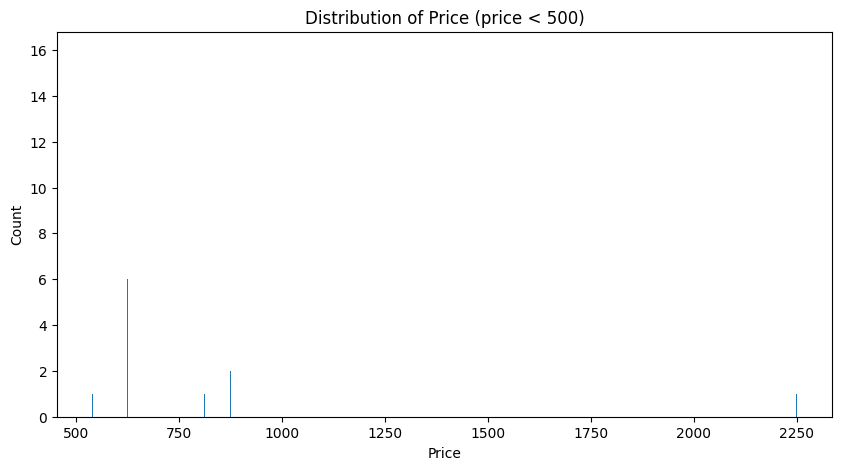

In [0]:
import matplotlib.pyplot as plt

# Filter for items with price < 500
# there are only how-to-manuals with price 0
filtered_df = item_df_parsed.filter((item_df_parsed["price"] > 500) )

age_counts = (
    filtered_df.groupBy("price")
      .count()
      .orderBy("price")
)

# Convert to Pandas for plotting
age_counts_pd = age_counts.toPandas()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(age_counts_pd["price"], age_counts_pd["count"])
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of Price (price < 500)")
plt.show()

In [0]:
from pyspark.sql.functions import desc

display(item_df_parsed.groupBy("price").count().orderBy(desc("count")))

price count 0.0 156 30.0 44 300.0 43 60.0 32 50.0 31 27.5 29 15.0 28 150.0 28 18.0 27 45.0 26 100.0 25 250.0 25 90.0 23 44.0 23 3.0 23 33.0 23 75.0 20 9.0 20 97.9 20 22.5 20 110.0 19 55.0 19 20.0 19 37.5 19 275.0 19 16.5 19 57.2 18 25.0 18 65.0 16 750.0 16 39.0 16 66.0 15 42.0 15 3.6 15 120.0 15 132.0 15 3.3 14 22.0 14 165.0 14 180.0 14 78.0 13 27.0 13 36.0 13 330.0 13 130.0 13 6.0 12 21.0 12 52.8 12 225.0 12 26.4 12 115.7 12 8.25 12 48.95 11 137.5 11 32.5 11 125.0 11 18.75 11 19.5 11 9.9 11 200.0 10 3.9 10 6.6 10 53.4 10 106.8 10 4.2 10 1.32 9 325.0 9 7.5 9 13.5 9 450.0 9 10.0 9 48.4 9 89.0 9 390.0 9 375.0 9 133.5 9 312.5 9 1.65 8 80.0 8 270.0 8 11.7 8 88.0 8 82.5 8 140.0 8 35.0 8 143.0 8 12.0 8 240.0 8 267.0 8 11.0 7 198.0 7 24.0 7 1.8 7 13.2 7 26.0 7 112.5 7 2.4 7 40.0 7 60.5 7 62.5 7 13.75 7 4.5 6 350.0 6 41.25 6 39.6 6 500.0 6 24.2 6 178.0 6 600.0 6 1.62 6 625.0 6 12.5 6 28.6 6 2.34 6 71.2 6 34.32 5 48.0 5 70.0 5 35.2 5 28.0 5 222.5 5 58.74 5 11.44 5 39.16 5 2.7 5 5.5 5 35.6 5 99.0 5 72.0 5 162.5 5 121.0 5 127.27 5 360.0 5 15.6 5 5.4 5 11.25 5 69.42 5 900.0 5 5.0 4 1.98 4 0.6 4 124.6 4 9.75 4 4.29 4 29.37 4 363.0 4 0.78 4 420.0 4 19.58 4 53.24 4 79.2 4 4.95 4 23.4 4 289.25 4 31.25 4 14.4 4 48.06 4 195.0 4 111.25 4 187.5 4 92.56 4 3.75 4 7.8 4 234.0 4 17.8 4 8.8 4 220.0 3 687.5 3 1.5 3 3.12 3 156.25 3 244.75 3 3.63 3 32.04 3 156.0 3 23.76 3 80.1 3 247.5 3 17.6 3 154.0 3 210.0 3 1.56 3 6.25 3 1.875 3 412.5 3 18.15 3 385.0 3 34.375 3 84.0 3 10.8 3 52.0 3 68.75 3 6.5 3 21.6 3 46.28 3 562.5 3 71.5 3 61.6 3 1.2 3 10.5 3 311.5 3 675.0 3 13.0 3 135.0 3 14.85 3 62.92 3 7.2 3 24.92 3 20.625 3 6.75 3 31.2 3 23.14 2 87.5 2 99.68 2 19.8 2 21.36 2 26.7 2 24.75 2 105.6 2 44.5 2 2.52 2 22.88 2 104.0 2 302.5 2 67.76 2 42.9 2 81.25 2 122.375 2 0.66 2 9.375 2 9.075 2 280.0 2 19.36 2 1.68 2 14.0 2 264.0 2 175.0 2 260.0 2 16.2 2 64.08 2 55.625 2 66.75 2 0.54 2 343.75 2 88.11 2 31.68 2 781.25 2 97.5 2 0.75 2 16.8 2 16.25 2 77.0 2 7.92 2 56.25 2 58.08 2 62.3 2 6.875 2 160.2 2 667.5 2 937.5 2 875.0 2 357.5 2 74.76 2 2.64 2 45.76 2 278.125 2 30.25 2 1.815 2 825.0 2 8.4 1 0.33 1 48.75 1 36.96 1 151.25 1 24.64 1 38.5 1 1250.0 1 181.5 1 36.3 1 0.72 1 25.2 1 15.125 1 33.75 1 252.0 1 1.08 1 30.8 1 312.0 1 168.0 1 213.6 1 38.72 1 216.0 1 145.2 1 7.0 1 93.75 1 21.45 1 107.69 1 105.0 1 112.0 1 40.05 1 43.56 1 14.52 1 22.25 1 49.28 1 52.5 1 67.5 1 46.875 1 540.0 1 480.0 1 23.1 1 660.0 1 8.1 1 144.0 1 15.84 1 54.0 1 96.8 1 2250.0 1 0.9 1 15.625 1 42.72 1 1875.0 1 9.68 1 108.0 1 26.62 1 12.6 1 297.0 1 12.32 1 2.1 1 2.88 1 200.25 1 162.0 1 29.04 1 1.35 1 9.79 1 195.8 1 990.0 1 812.5 1

In [0]:
display(item_df_parsed.filter(item_df_parsed["price"] == 0))

adjective category created_at id modifier name price null instrument 2013-10-07T09:38:14.000Z 1178 how-to-manual instrument how-to-manual 0.0 organic tool 2013-09-09T11:36:06.000Z 107 how-to-manual organic tool how-to-manual 0.0 reflective mechanism 2014-01-21T07:14:49.000Z 1602 how-to-manual reflective mechanism how-to-manual 0.0 matte widget 2013-03-16T00:16:33.000Z 2389 how-to-manual matte widget how-to-manual 0.0 rechargable dongle 2013-03-16T00:54:44.000Z 1732 how-to-manual rechargable dongle how-to-manual 0.0 matte apparatus 2013-05-07T17:28:21.000Z 2309 how-to-manual matte apparatus how-to-manual 0.0 extra-strength instrument 2013-12-17T09:39:55.000Z 1756 how-to-manual extra-strength instrument how-to-manual 0.0 reflective gadget 2013-04-20T03:43:10.000Z 864 how-to-manual reflective gadget how-to-manual 0.0 rechargable gadget 2013-05-06T04:53:15.000Z 3842 how-to-manual rechargable gadget how-to-manual 0.0 glossy apparatus 2013-12-27T19:25:09.000Z 1545 how-to-manual glossy apparatus how-to-manual 0.0 reflective device 2013-08-08T20:33:46.000Z 2903 how-to-manual reflective device how-to-manual 0.0 rechargable widget 2013-05-11T15:27:00.000Z 3772 how-to-manual rechargable widget how-to-manual 0.0 null tool 2013-12-04T03:19:50.000Z 1082 how-to-manual tool how-to-manual 0.0 glossy widget 2013-07-12T18:40:24.000Z 1437 how-to-manual glossy widget how-to-manual 0.0 matte dongle 2013-12-05T01:04:18.000Z 413 how-to-manual matte dongle how-to-manual 0.0 glossy mechanism 2013-08-07T22:15:44.000Z 3724 how-to-manual glossy mechanism how-to-manual 0.0 digital gadget 2013-03-27T13:54:49.000Z 3466 how-to-manual digital gadget how-to-manual 0.0 extra-strength mechanism 2013-07-04T14:22:28.000Z 2795 how-to-manual extra-strength mechanism how-to-manual 0.0 rechargable contraption 2014-01-12T04:08:43.000Z 2170 how-to-manual rechargable contraption how-to-manual 0.0 extra-strength tool 2013-10-26T04:06:54.000Z 2995 how-to-manual extra-strength tool how-to-manual 0.0 fuzzy gadget 2013-08-12T22:03:15.000Z 416 how-to-manual fuzzy gadget how-to-manual 0.0 null widget 2013-04-23T19:38:07.000Z 2073 how-to-manual widget how-to-manual 0.0 industrial-strength instrument 2013-05-31T07:35:10.000Z 2668 how-to-manual industrial-strength instrument how-to-manual 0.0 fuzzy instrument 2014-02-18T12:15:35.000Z 3250 how-to-manual fuzzy instrument how-to-manual 0.0 rechargable device 2013-08-14T21:00:54.000Z 1241 how-to-manual rechargable device how-to-manual 0.0 reflective contraption 2013-05-26T04:40:19.000Z 422 how-to-manual reflective contraption how-to-manual 0.0 glossy module 2014-02-08T05:49:12.000Z 3240 how-to-manual glossy module how-to-manual 0.0 industrial-strength instrument 2013-12-14T13:28:09.000Z 1747 how-to-manual industrial-strength instrument how-to-manual 0.0 extra-strength gadget 2013-07-21T04:14:33.000Z 1163 how-to-manual extra-strength gadget how-to-manual 0.0 industrial-strength contraption 2013-04-18T06:06:47.000Z 2756 how-to-manual industrial-strength contraption how-to-manual 0.0 analog tool 2013-07-17T17:33:36.000Z 1363 how-to-manual analog tool how-to-manual 0.0 matte mechanism 2013-05-02T16:02:08.000Z 1146 how-to-manual matte mechanism how-to-manual 0.0 prize-winning dongle 2014-01-12T02:01:42.000Z 215 how-to-manual prize-winning dongle how-to-manual 0.0 matte gadget 2013-06-21T05:54:49.000Z 3685 how-to-manual matte gadget how-to-manual 0.0 extra-strength module 2013-06-08T15:23:32.000Z 911 how-to-manual extra-strength module how-to-manual 0.0 extra-strength gadget 2014-01-15T11:37:37.000Z 2022 how-to-manual extra-strength gadget how-to-manual 0.0 digital apparatus 2013-07-05T14:25:31.000Z 1883 how-to-manual digital apparatus how-to-manual 0.0 organic widget 2013-05-30T15:44:59.000Z 250 how-to-manual organic widget how-to-manual 0.0 matte tool 2013-03-29T20:53:01.000Z 1594 how-to-manual matte tool how-to-manual 0.0 null instrument 2014-02-24T11:23:42.000Z 2229 how-to-manual instrument how-to-manual 0.0 fuzzy instrument 2014-01-20T2

In [0]:
display(item_df_parsed.filter(col("price") > 1000.0))

adjective category created_at id modifier name price extra-strength contraption 2013-09-19T23:15:58.000Z 2592 storage_unit extra-strength contraption storage_unit 1250.0 industrial-strength apparatus 2013-03-30T01:18:30.000Z 2354 storage_unit industrial-strength apparatus storage_unit 2250.0 industrial-strength contraption 2014-01-14T15:42:03.000Z 669 storage_unit industrial-strength contraption storage_unit 1875.0

There are only 3 items above 1000 and 59 above 500.

Check the quantiles of the prices

In [0]:
# Get quantiles for price distinctstribution
quantiles = item_df_parsed.approxQuantile(
    "price",
    [0.0, 0.25, 0.5, 0.75, 1.0],   # quartiles
    0.01                           # relative error tolerance
)

print("Quantiles:", quantiles)


Quantiles: [0.0, 13.75, 40.0, 111.25, 2250.0]


Use them as bucket splits?

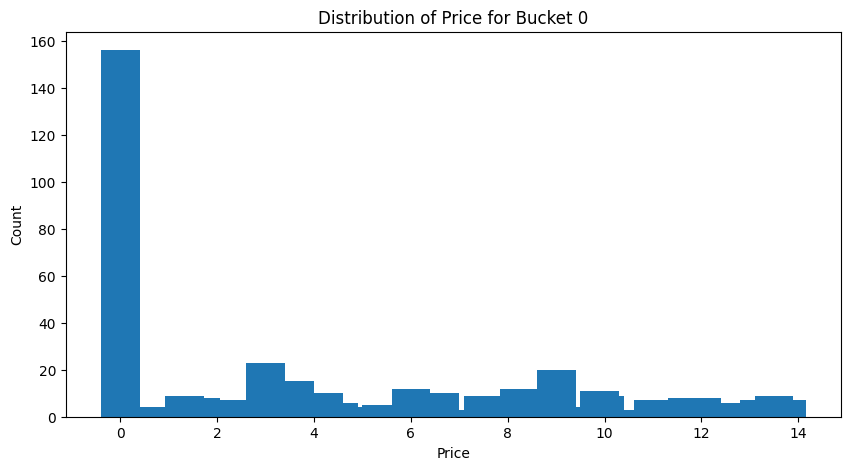

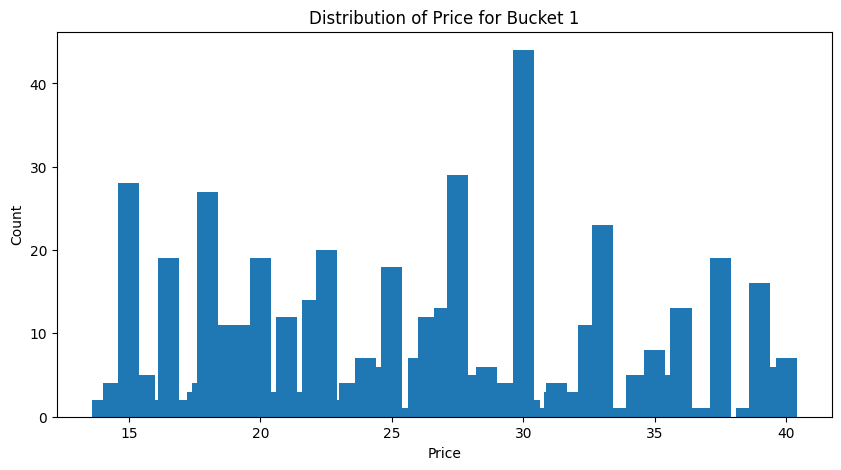

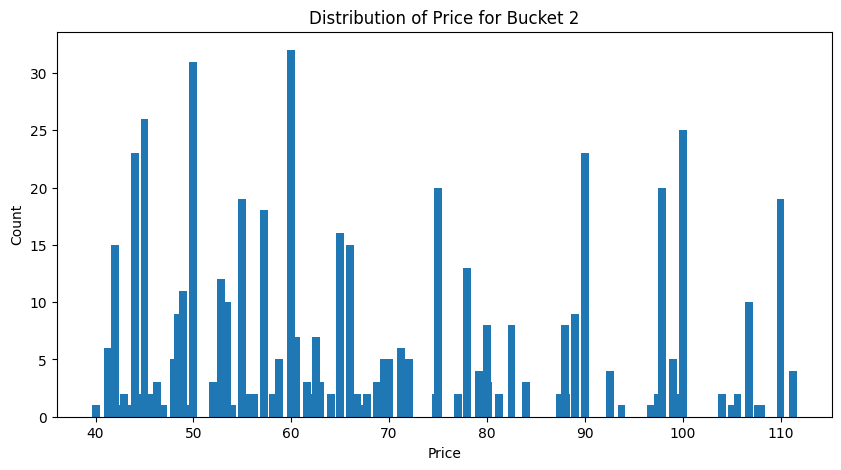

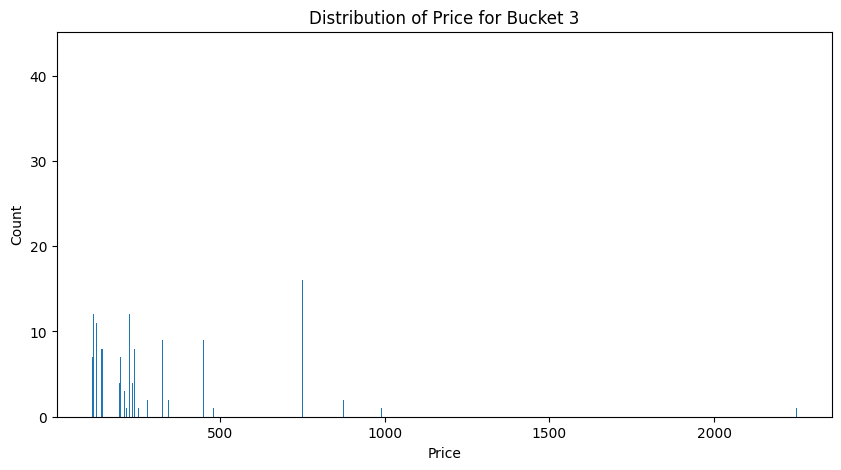

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Get unique bucket values using DataFrame API
buckets = [
    row["price_bucket"]
    for row in item_df_parsed.select("price_bucket")
    .distinct()
    .orderBy("price_bucket")
    .collect()
]

for bucket in buckets:
    bucket_df = item_df_parsed.filter(F.col("price_bucket") == bucket)
    price_counts = (
        bucket_df.groupBy("price")
        .count()
        .orderBy("price")
    )
    price_counts_pd = price_counts.toPandas()
    plt.figure(figsize=(10, 5))
    plt.bar(price_counts_pd["price"], price_counts_pd["count"])
    plt.xlabel("Price")
    plt.ylabel("Count")
    plt.title(f"Distribution of Price for Bucket {bucket}")
    plt.show()

In [0]:
import matplotlib.pyplot as plt

# Filter for items with price < 500
# there are only how-to-manuals with price 0
filtered_df = item_df_parsed.filter((item_df_parsed["price"] < 500) & (item_df_parsed["price"] != 0))

age_counts = (
    filtered_df.groupBy("price")
      .count()
      .orderBy("price")
)

# Convert to Pandas for plotting
age_counts_pd = age_counts.toPandas()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(age_counts_pd["price"], age_counts_pd["count"])
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of Price (price < 500)")
plt.show()

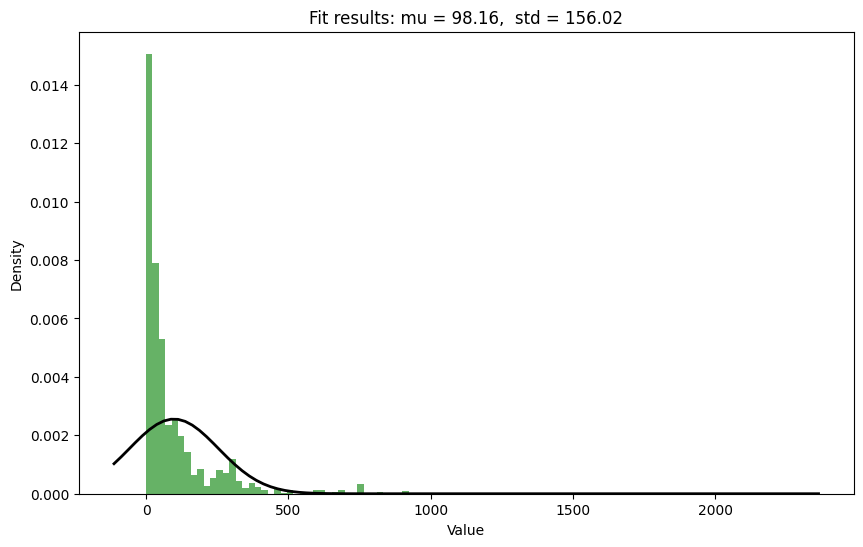

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

# Step 1: Collect your column from Spark
# Suppose your column is "value"
pdf = item_df_parsed.select("price").toPandas()

# Step 2: Extract values
data = pdf["price"].dropna().values

# Step 3: Plot histogram
plt.figure(figsize=(10, 6))
count, bins, _ = plt.hist(data, bins=100, density=True, alpha=0.6, color='g')

# Step 4: Fit Gaussian
mu, std = norm.fit(data)

# Step 5: Plot Gaussian curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.title(f"Fit results: mu = {mu:.2f},  std = {std:.2f}")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()


In [0]:
# Assign price buckets using when/otherwise instead of Bucketizer
from pyspark.sql.functions import when
# Use quantiles as splits
splits = quantiles
splits[0] = float("-inf")   # allow anything below min
splits[-1] = float("inf")   # allow anything above max



bucket_conditions = (
    when(F.col("price") <= splits[1], 0)
    .when((F.col("price") > splits[1]) & (F.col("price") <= splits[2]), 1)
    .when((F.col("price") > splits[2]) & (F.col("price") <= splits[3]), 2)
    .otherwise(3)
)
item_df_parsed = item_df_parsed.withColumn("price_bucket", bucket_conditions)
display(item_df_parsed.select("price", "price_bucket"))



price price_bucket 150.0 3 35.2 1 300.0 3 16.5 1 16.5 1 195.0 3 0.0 0 41.25 2 15.0 1 37.5 1 80.0 2 40.0 1 0.78 0 0.0 0 60.0 2 213.6 3 21.0 1 540.0 3 15.0 1 13.75 0 39.16 1 20.0 1 15.0 1 0.0 0 13.5 0 6.0 0 39.0 1 22.5 1 0.0 0 48.06 2 18.0 1 0.0 0 9.0 0 33.0 1 120.0 3 312.5 3 198.0 3 4.2 0 300.0 3 0.0 0 80.0 2 70.0 2 16.5 1 330.0 3 7.5 0 1.32 0 0.6 0 244.75 3 48.4 2 27.5 1 99.0 2 300.0 3 250.0 3 270.0 3 0.0 0 55.0 2 27.5 1 1.5 0 10.8 0 31.68 1 18.0 1 22.25 1 100.0 2 60.5 2 30.0 1 130.0 3 44.0 2 19.58 1 80.0 2 115.7 3 300.0 3 35.6 1 210.0 3 18.75 1 275.0 3 100.0 2 12.5 0 5.5 0 11.7 0 27.5 1 9.0 0 57.2 2 121.0 3 107.69 2 0.0 0 15.0 1 75.0 2 65.0 2 90.0 2 53.24 2 222.5 3 30.0 1 44.0 2 96.8 2 42.0 2 110.0 2 8.25 0 27.5 1 23.4 1 9.0 0 1.68 0 10.0 0 625.0 3 71.2 2 11.44 0 195.0 3 312.5 3 270.0 3 50.0 2 111.25 2 24.75 1 140.0 3 150.0 3 110.0 2 3.0 0 937.5 3 15.0 1 300.0 3 44.0 2 150.0 3 300.0 3 127.27 3 750.0 3 50.0 2 75.0 2 27.5 1 7.5 0 390.0 3 17.6 1 30.0 1 325.0 3 0.0 0 48.0 2 41.25 2 15.0 1 2.34 0 562.5 3 250.0 3 33.0 1 80.0 2 24.75 1 175.0 3 7.92 0 24.2 1 22.0 1 110.0 2 15.0 1 30.0 1 13.0 0 80.0 2 143.0 3 11.7 0 58.08 2 2.7 0 39.0 1 250.0 3 60.0 2 100.0 2 0.54 0 420.0 3 45.0 2 88.0 2 3.6 0 65.0 2 71.5 2 6.25 0 2.4 0 4.95 0 19.5 1 270.0 3 375.0 3 375.0 3 78.0 2 27.5 1 27.0 1 42.0 2 22.5 1 165.0 3 132.0 3 0.0 0 1.5 0 58.74 2 18.0 1 300.0 3 38.72 1 0.0 0 3.9 0 900.0 3 89.0 2 165.0 3 300.0 3 39.6 1 0.33 0 225.0 3 3.6 0 187.5 3 150.0 3 6.0 0 65.0 2 6.5 0 3.0 0 289.25 3 0.0 0 35.6 1 41.25 2 165.0 3 9.0 0 1.65 0 27.5 1 132.0 3 22.0 1 3.6 0 9.9 0 375.0 3 17.6 1 24.2 1 20.0 1 15.625 1 30.0 1 6.0 0 74.76 2 22.5 1 16.5 1 15.0 1 0.0 0 97.9 2 625.0 3 178.0 3 2.4 0 0.0 0 363.0 3 343.75 3 0.0 0 42.0 2 52.5 2 100.0 2 16.5 1 5.5 0 79.2 2 25.0 1 3.0 0 8.25 0 10.0 0 9.0 0 65.0 2 130.0 3 97.9 2 45.0 2 36.0 1 275.0 3 2.1 0 34.32 1 37.5 1 375.0 3 15.0 1 16.5 1 250.0 3 122.375 3 275.0 3 48.0 2 300.0 3 125.0 3 300.0 3 135.0 3 33.0 1 17.8 1 250.0 3 90.0 2 60.0 2 48.4 2 18.75 1 180.0 3 137.5 3 36.0 1 75.0 2 750.0 3 11.7 0 19.5 1 289.25 3 90.0 2 1.8 0 9.0 0 0.0 0 9.0 0 135.0 3 75.0 2 363.0 3 97.5 2 6.6 0 140.0 3 0.0 0 72.0 2 27.5 1 36.0 1 0.0 0 52.8 2 18.75 1 127.27 3 97.9 2 10.5 0 12.5 0 9.9 0 115.7 3 3.9 0 200.0 3 150.0 3 100.0 2 124.6 3 82.5 2 4.2 0 42.0 2 252.0 3 4.2 0 55.0 2 48.95 2 267.0 3 33.0 1 44.5 2 8.25 0 16.5 1 0.0 0 1.62 0 7.5 0 216.0 3 48.95 2 247.5 3 34.375 1 195.0 3 20.0 1 77.0 2 330.0 3 55.0 2 44.0 2 3.6 0 30.0 1 60.0 2 0.0 0 15.0 1 31.25 1 300.0 3 106.8 2 92.56 2 99.0 2 178.0 3 240.0 3 88.0 2 26.7 1 0.78 0 68.75 2 21.0 1 62.92 2 4.5 0 390.0 3 15.0 1 120.0 3 48.0 2 36.0 1 10.0 0 60.0 2 75.0 2 225.0 3 27.5 1 0.0 0 3.0 0 57.2 2 46.875 2 150.0 3 70.0 2 7.2 0 120.0 3 125.0 3 11.44 0 6.875 0 1.65 0 300.0 3 106.8 2 8.25 0 130.0 3 48.4 2 78.0 2 16.5 1 137.5 3 0.0 0 250.0 3 120.0 3 55.0 2 31.2 1 0.0 0 150.0 3 84.0 2 750.0 3 23.4 1 34.32 1 58.74 2 22.5 1 29.37 1 45.0 2 154.0 3 15.0 1 180.0 3 25.2 1 7.5 0 11.0 0 7.92 0 33.0 1 50.0 2 125.0 3 240.0 3 3.9 0 390.0 3 120.0 3 0.0 0 10.0 0 66.0 2 39.0 1 180.0 3 50.0 2 44.0 2 9.9 0 300.0 3 15.0 1 0.0 0 90.0 2 44.5 2 16.5 1 3.9 0 71.2 2 25.0 1 0.0 0 187.5 3 67.76 2 0.0 0 39.6 1 19.5 1 1.98 0 25.0 1 15.125 1 42.72 2 60.0 2 110.0 2 11.0 0 44.0 2 22.0 1 45.0 2 88.0 2 42.0 2 6.5 0 4.2 0 36.0 1 37.5 1 198.0 3 78.0 2 240.0 3 11.25 0 19.58 1 151.25 3 300.0 3 89.0 2 45.0 2 55.0 2 600.0 3 36.0 1 120.0 3 30.0 1 130.0 3 1.32 0 3.0 0 42.0 2 27.0 1 32.5 1 150.0 3 625.0 3 27.0 1 4.2 0 36.0 1 143.0 3 100.0 2 137.5 3 15.84 1 52.8 2 78.0 2 115.7 3 55.625 2 13.75 0 7.0 0 0.0 0 18.0 1 60.0 2 66.0 2 23.76 1 75.0 2 110.0 2 385.0 3 33.0 1 3.3 0 121.0 3 64.08 2 22.5 1 300.0 3 29.37 1 9.75 0 289.25 3 27.5 1 130.0 3 60.0 2 44.0 2 2.34 0 200.25 3 0.0 0 35.0 1 250.0 3 33.0 1 69.42 2 37.5 1 39.0 1 24.64 1 312.5 3 55.0 2 500.0 3 36.0 1 10.0 0 1.32 0 267.0 3 675.0 3 250.0 3 125.0 3 82.5 2 9.9 0 110.0 2 22.5 1 1.2 0 50.0 2 6.75 0 275.0 3 300.0 3 4.5 0 25.0 1 0.0 0 10.5 0 30.0 1 0.9 0 450.0 3 19.8 1 45.0 2 52.8 2 27.5 1 75.0 2 0.0 0 30.0 1 

## Useful partitions:
Period of the year (vacations, Christmas, Black Friday) might be when the most expensive ones get sold -> don't do sales
Time of the day (working hours, past midnight) might be when the cheapest ones get sold -> increase their price
Price bucket
platforms
product adjective, modifier, category

#  Layer 3: Datamart

In [0]:
event_df_parsed.printSchema()
item_df_parsed.printSchema()

root
 |-- event_id: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- payload_event_name: string (nullable = true)
 |-- payload_platform: string (nullable = true)
 |-- payload_parameter_name: string (nullable = true)
 |-- payload_parameter_value: string (nullable = true)

root
 |-- adjective: string (nullable = true)
 |-- category: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- id: integer (nullable = true)
 |-- modifier: string (nullable = true)
 |-- name: string (nullable = true)
 |-- price: float (nullable = true)



In [0]:
item_df_parsed = spark.read.format("delta").load(f"{bucket}/silver/item_clean")
event_df_parsed = spark.read.format("delta").load(f"{bucket}/silver/event_fact")

In [0]:
event_df_parsed.printSchema()
item_df_parsed.printSchema()

root
 |-- event_id: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- payload_event_name: string (nullable = true)
 |-- payload_platform: string (nullable = true)
 |-- payload_parameter_name: string (nullable = true)
 |-- payload_parameter_value: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)

root
 |-- adjective: string (nullable = true)
 |-- category: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- id: integer (nullable = true)
 |-- modifier: string (nullable = true)
 |-- name: string (nullable = true)
 |-- price: float (nullable = true)
 |-- price_bucket: string (nullable = true)



In [0]:
display(event_df_parsed.head(3))

event_id event_time user_id payload_event_name payload_platform payload_parameter_name payload_parameter_value year month 50e6a6d00111460e9f6acdbd94f500a4 2014-09-06T13:10:31.000Z 29614 view_user_profile iOS viewed_user_id 1393 2014 9 f53ec02b56294112aff8acbaecd52037 2014-09-06T14:13:59.000Z 32808 view_user_profile web viewed_user_id 37415 2014 9 45c935c652774f1bb92141a546b392d4 2014-09-22T16:23:32.000Z 11059 view_user_profile web viewed_user_id 31459 2014 9

In [0]:
display(item_df_parsed.head(3))

adjective category created_at id modifier name price price_bucket organic tool 2013-06-24T15:10:15.000Z 1606 warmer organic tool warmer 41.25 medium-high industrial-strength tool 2013-04-15T04:41:01.000Z 1273 cleaner industrial-strength tool cleaner 45.0 medium-high industrial-strength tool 2013-12-07T22:22:05.000Z 207 null industrial-strength tool 75.0 medium-high

### Total number of item views in a particular year.

In [0]:
from pyspark.sql import functions as F, Window

#particular_year = 2016
# Filter to only 'view_item' events
views_df = (
    event_df_parsed
    .filter(
        #(F.col("year") == particular_year) &
        (F.col("payload_event_name") == "view_item")
      & (F.col("payload_parameter_name") == "item_id"))
    .withColumnRenamed("payload_platform", "platform")
    .withColumnRenamed("payload_event_name", "event_name")
)

# Join with item dimension
views_with_items = (
    views_df.join(item_df_parsed, views_df["payload_parameter_value"] == item_df_parsed["id"], "inner")
)

# Aggregate: total views + most used platform
agg_df = (
    views_with_items
    .groupBy("id", "name", "year")
    .agg(
        F.count("*").alias("total_views"),
        F.expr("mode() within group (order by platform)").alias("most_used_platform")  # only works with Spark SQL 3.x
    )
    .orderBy("id", "total_views")
)

# Add ranking by total views per year
window_rank = Window.partitionBy("year").orderBy(F.desc("total_views"))
top_item_df = agg_df.withColumn("rank", F.dense_rank().over(window_rank))


In [0]:
display(top_item_df)

id name year total_views most_used_platform rank 3517 prize-winning widget wrapper 2013 12 web 1 2086 organic device 2013 12 web 1 3063 fuzzy gadget wrapper 2013 11 web 2 3200 prize-winning widget refill 2013 10 web 3 3309 industrial-strength dongle 2013 10 mobile web 3 3538 organic dongle 2013 10 web 3 3978 fuzzy dongle 2013 10 android 3 3264 organic dongle wrapper 2013 9 iOS 4 80 rechargable module cleaner 2013 9 mobile web 4 138 matte widget refill 2013 9 web 4 265 glossy dongle 2013 9 web 4 760 analog widget 2013 9 web 4 1455 miniature apparatus how-to-manual 2013 9 web 4 1772 matte widget refill 2013 9 iOS 4 2498 aerodynamic widget 2013 9 web 4 2577 fuzzy apparatus 2013 9 web 4 2986 organic gadget carrying_case 2013 9 web 4 3405 extra-strength mechanism storage_unit 2013 9 web 4 3854 miniature module cleaner 2013 9 web 4 63 miniature device how-to-manual 2013 8 web 5 457 industrial-strength contraption 2013 8 web 5 1064 aerodynamic contraption warmer 2013 8 android 5 1311 digital widget storage_unit 2013 8 web 5 1586 extra-strength widget opener 2013 8 web 5 2203 reflective gadget warmer 2013 8 web 5 2357 reflective dongle how-to-manual 2013 8 web 5 2764 fuzzy apparatus warmer 2013 8 web 5 3070 rechargable contraption wrapper 2013 8 web 5 3285 extra-strength dongle carrying_case 2013 8 mobile web 5 3768 glossy apparatus 2013 8 iOS 5 3865 mechanism 2013 8 android 5 104 matte device carrying_case 2013 8 mobile web 5 293 instrument storage_unit 2013 8 web 5 373 aerodynamic dongle 2013 8 web 5 374 aerodynamic module 2013 8 iOS 5 1048 miniature apparatus refill 2013 8 web 5 1340 industrial-strength instrument 2013 8 web 5 1354 matte widget opener 2013 8 web 5 1888 aerodynamic device 2013 8 web 5 1975 tool refill 2013 8 mobile web 5 2088 apparatus 2013 8 web 5 2261 industrial-strength widget 2013 8 web 5 2422 glossy contraption 2013 8 web 5 2563 organic device opener 2013 8 web 5 2678 digital dongle 2013 8 web 5 2705 fuzzy contraption storage_unit 2013 8 web 5 2747 contraption charger 2013 8 iOS 5 2751 miniature dongle 2013 8 web 5 3005 analog device 2013 8 web 5 3509 apparatus how-to-manual 2013 8 web 5 3601 prize-winning device wrapper 2013 8 web 5 3631 instrument cleaner 2013 8 web 5 3762 aerodynamic dongle 2013 8 web 5 3795 analog module 2013 8 web 5 3799 miniature tool 2013 8 web 5 3869 analog device 2013 8 android 5 3955 fuzzy contraption opener 2013 8 web 5 399 reflective mechanism wrapper 2013 7 web 6 502 organic device wrapper 2013 7 web 6 630 glossy contraption 2013 7 web 6 655 reflective tool wrapper 2013 7 web 6 1049 miniature mechanism 2013 7 web 6 1098 gadget cleaner 2013 7 web 6 1114 matte apparatus 2013 7 web 6 1177 analog mechanism warmer 2013 7 android 6 1204 fuzzy contraption 2013 7 mobile web 6 1315 reflective dongle carrying_case 2013 7 web 6 1400 aerodynamic tool storage_unit 2013 7 web 6 1788 fuzzy mechanism charger 2013 7 android 6 1808 tool charger 2013 7 web 6 1870 digital contraption 2013 7 web 6 1936 glossy widget 2013 7 mobile web 6 2140 aerodynamic contraption cleaner 2013 7 iOS 6 2250 reflective widget warmer 2013 7 web 6 2386 industrial-strength instrument storage_unit 2013 7 android 6 2413 extra-strength gadget carrying_case 2013 7 mobile web 6 2504 reflective mechanism charger 2013 7 web 6 2535 reflective dongle cleaner 2013 7 android 6 2646 reflective device refill 2013 7 web 6 2908 rechargable widget carrying_case 2013 7 android 6 3036 extra-strength mechanism charger 2013 7 iOS 6 3165 extra-strength gadget opener 2013 7 web 6 3191 glossy module how-to-manual 2013 7 web 6 3482 extra-strength contraption opener 2013 7 web 6 3668 extra-strength gadget wrapper 2013 7 web 6 106 analog widget carrying_case 2013 7 web 6 180 glossy instrument 2013 7 web 6 221 analog contraption opener 2013 7 android 6 274 extra-strength instrument carrying_case 2013 7 web 6 396 widget charger 2013 7 iOS 6 426 analog apparatus wrapper 2013 7 mobile web 6 489 prize-winning module cleaner 2013 7 iOS 6 506 aerodynamic a

In [0]:

# Save to Gold layer
top_item_df.write \
    .mode("overwrite") \
    .format("delta") \
    .save(f"{bucket}/gold_layer/top_item")